Importar librerías

In [4]:
import cv2
import numpy as np
import sys
import tifffile as tf
import glob
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt

Función para leer imágenes

In [5]:
# Reads all the files and returns a list of images with 3 channels
# (brightfield, GPT, mCheery)
def read_files(path):
    files = glob.glob(f"{path}/*.tif")
    files = sorted(files)
    images = []

    for idx in range(len(files)//3):

        im = np.empty((520, 696, 3))
        for i in range(3):
            im[:,:,i] = tf.imread(files[idx*3 + i])
        images.append(im)

    return images

Leer imágenes del conjunto de datos

--------------------------------------------------------------------------------------------------------------------------------------------
                                                                 IMAGEN 1
--------------------------------------------------------------------------------------------------------------------------------------------


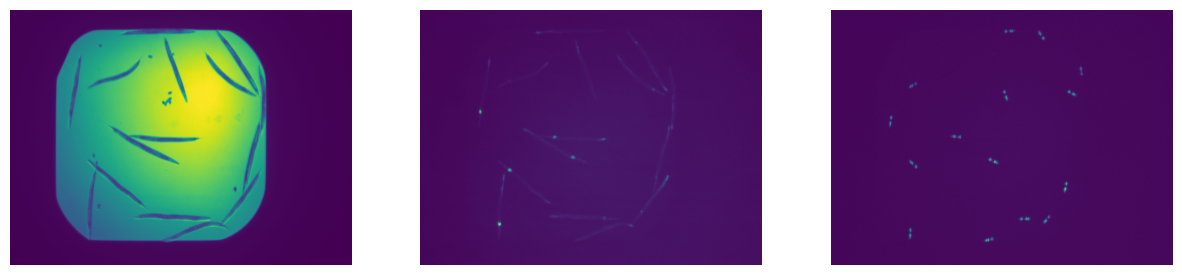

--------------------------------------------------------------------------------------------------------------------------------------------
                                                                 IMAGEN 2
--------------------------------------------------------------------------------------------------------------------------------------------


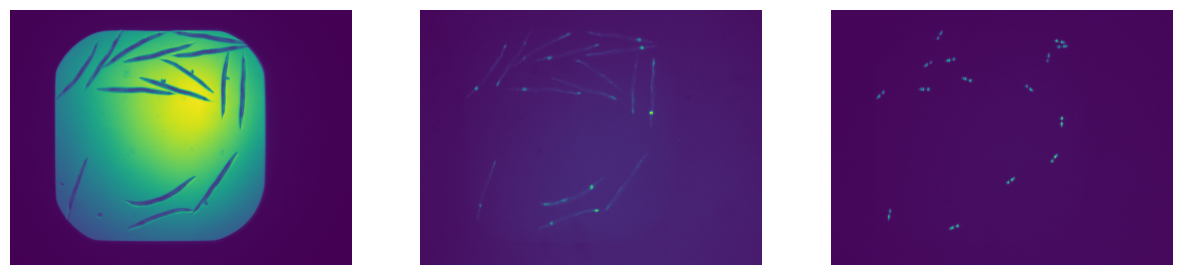

--------------------------------------------------------------------------------------------------------------------------------------------
                                                                 IMAGEN 3
--------------------------------------------------------------------------------------------------------------------------------------------


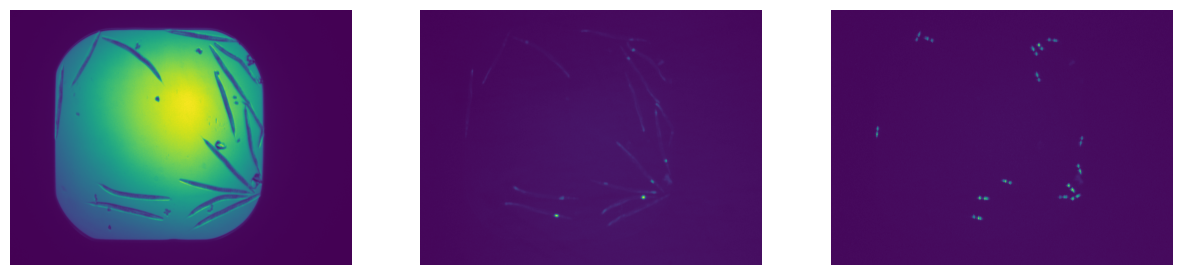

--------------------------------------------------------------------------------------------------------------------------------------------
                                                                 IMAGEN 4
--------------------------------------------------------------------------------------------------------------------------------------------


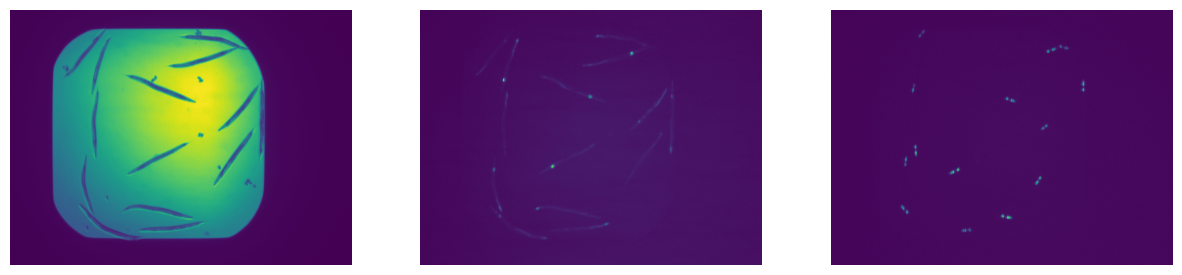

--------------------------------------------------------------------------------------------------------------------------------------------
                                                                 IMAGEN 5
--------------------------------------------------------------------------------------------------------------------------------------------


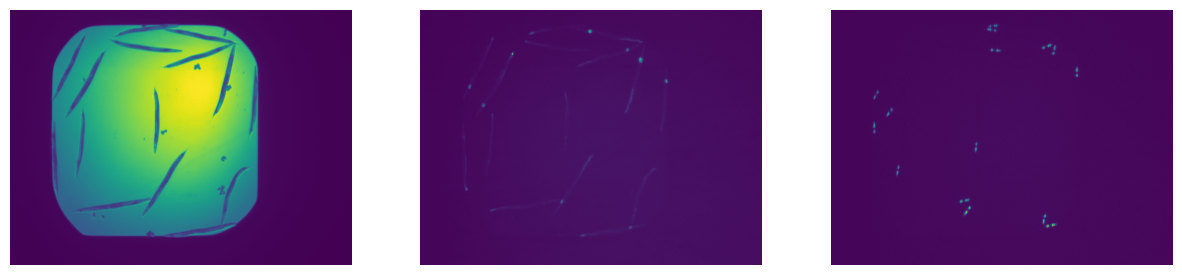

--------------------------------------------------------------------------------------------------------------------------------------------
                                                                 IMAGEN 6
--------------------------------------------------------------------------------------------------------------------------------------------


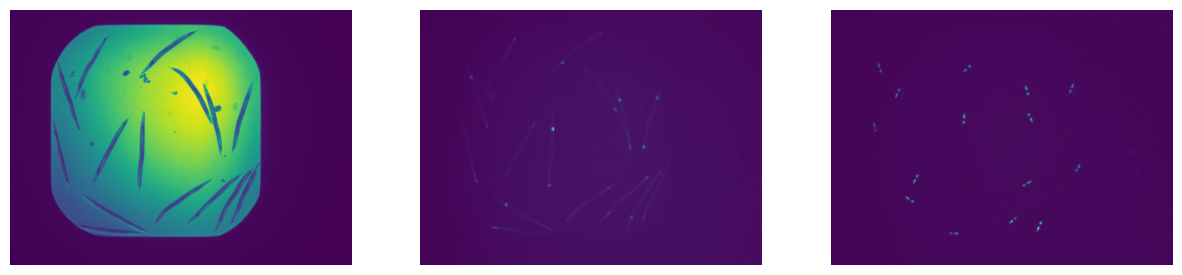

In [6]:
path = "D:/MUBICS/Imagen_Biomedica/Practicas/P1/dataset/dataset" # Set this variable to the appropriate path
images = read_files(path)

plt.rcParams["figure.figsize"] = [15,10]

n_images = 1
for im in images:
    fig, ax = plt.subplots(1,3)
    print("-"*140)
    print(" "*65 + "IMAGEN {}".format(n_images))
    print("-"*140)
    n_images += 1
    for i in range(3):
        ax[i].axis('off')
        ax[i].imshow(im[:,:,i])
    plt.show()

# Tarea 1: Segmentación de individuos
Utilizaré el canal w1 (campo claro) para identicar los bordes de los nematodos. Primero debemos transformar el rango de intensidades del fichero tiff (entre 100 y 2000) a valores entre 0 y 255 para poder usar las librerías de procesado de imagen.

---------------------------------------------------------------------------
                                   IMAGEN 1
---------------------------------------------------------------------------
Intensidad máxima: 255
Intensidad mínima: 0


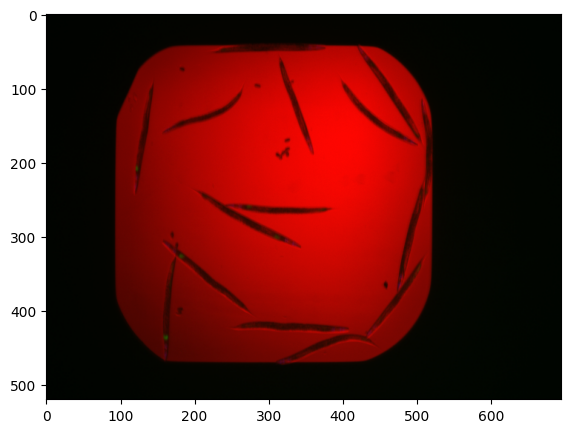

---------------------------------------------------------------------------
                                   IMAGEN 2
---------------------------------------------------------------------------
Intensidad máxima: 255
Intensidad mínima: 0


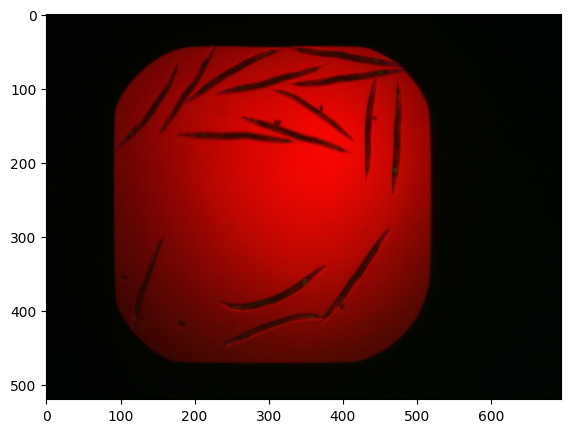

---------------------------------------------------------------------------
                                   IMAGEN 3
---------------------------------------------------------------------------
Intensidad máxima: 255
Intensidad mínima: 0


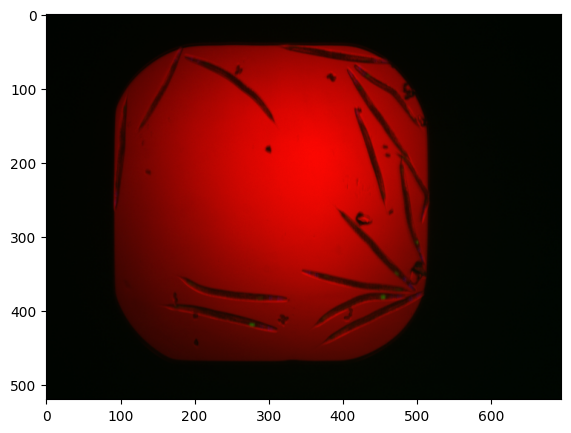

---------------------------------------------------------------------------
                                   IMAGEN 4
---------------------------------------------------------------------------
Intensidad máxima: 255
Intensidad mínima: 0


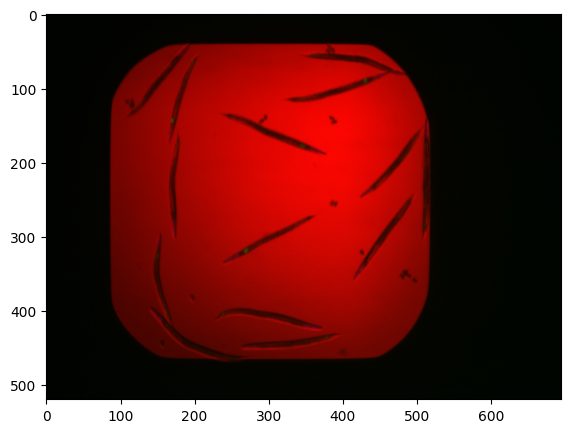

---------------------------------------------------------------------------
                                   IMAGEN 5
---------------------------------------------------------------------------
Intensidad máxima: 255
Intensidad mínima: 0


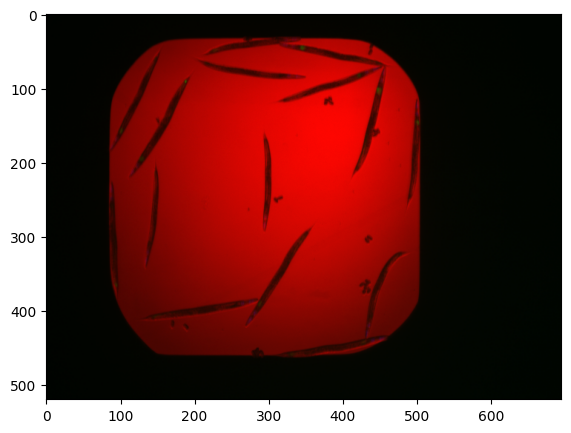

---------------------------------------------------------------------------
                                   IMAGEN 6
---------------------------------------------------------------------------
Intensidad máxima: 255
Intensidad mínima: 0


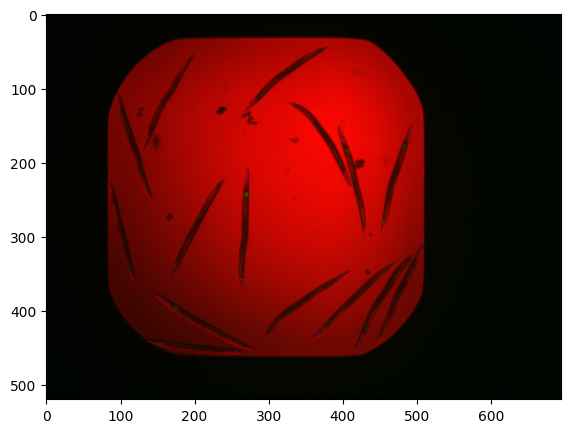

In [7]:
from skimage.exposure import rescale_intensity

images_rescaled = []

plt.rcParams["figure.figsize"] = [10,5]

for i in range(len(images)):
    # reescalamos el rango de intensidades
    image_rescaled = rescale_intensity(images[i], in_range='image', out_range=(0,255)).astype(np.uint8)
    images_rescaled.append(image_rescaled)

    print("-"*75)
    print(" "*35 + "IMAGEN {}".format(i+1))
    print("-"*75)
    print("Intensidad máxima: {}".format(np.max(image_rescaled))) # Maximo global de la imagen
    print("Intensidad mínima: {}".format(np.min(image_rescaled))) # Mínimo global de la imagen
    plt.imshow(image_rescaled, cmap='gray', vmin=0, vmax=255)
    plt.show()

Ahora realizamos la segmentación. El flujo de trabajo que he decidido realizar ha sido el siguiente:

1. **Umbralización adaptativa:**
Decidí realizar una umbralización adaptativa debido a la inconsistencia en la luminosidad a lo largo de la imagen.

2. **Apertura:**
La apertura utilizando un kernel de 5x5 en forma de elipse tras la umbralización permitió separar correctamente los nematodos próximos entre sí o al borde exterior. La elección de este kernel se hizo tomando en cuenta la forma de los nematodos.

3. **Segmentación:**
Permitió distinguir y otorgar a cada objeto todavía presente en la imagen un identificador.

4. **Filtrado por área:**
Se establecieron unas áreas máximas y mínimas, que permitieron excluir el borde exterior y el ruido (puntos), respectivamente. Obteniendo una nueva máscara.

5. **Segunda segmentación:**
Se volvieron a etiquetar cada uno de los objetos presentes en la imagen final.



In [8]:
def segmentar_nematodos(imagen, plot=True):

    # Umbralización adaptativa
    adaptThr = cv2.adaptiveThreshold(imagen, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 19, 5)

    # Apertura para reducir ruido
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)) 
    opening = cv2.morphologyEx(adaptThr, cv2.MORPH_OPEN, kernel, iterations=1)

    # Segmentación
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(opening)

    # Crear una máscara para filtrar los objetos pequeños y el borde
    filtered_mask = np.zeros_like(opening)

    # Definir un umbral para eliminar puntos pequeños (ruido) y borde exterior
    area_threshold_min = 250 # para eliminar puntos
    area_threshold_max = 4000 # para eliminar el borde exterior
    
    # Eliminar borde exterior y ruido
    for i in range(1, num_labels):  # Evitamos el fondo (label 0)
        _, _, _, _, area = stats[i] # area: Cantidad de píxeles del objeto detectado
        if area < area_threshold_max and area > area_threshold_min:
            filtered_mask[labels == i] = 255  

    # Nueva segmentación sobre la máscara
    num_labels2, labels2, stats2, centroids2 = cv2.connectedComponentsWithStats(filtered_mask)

    # Gráficos (se pueden desactivar con el parámetro plot=False)
    if plot == True:
        fig, ax = plt.subplots(2,3, figsize=(15,8))
        
        # Imagen original
        ax[0,0].imshow(imagen, cmap='gray')
        ax[0,0].set_title("Imagen original\n (en escala de grises)")
        # Umbralización adaptativa
        ax[0,1].imshow(adaptThr, cmap='gray')
        ax[0,1].set_title("Umbralización adaptativa")
        # Apertura
        ax[0,2].imshow(opening, cmap='gray')
        ax[0,2].set_title("Apertura")
        # Segmentación
        ax[1,0].imshow(labels, cmap="nipy_spectral")
        ax[1,0].set_title("Segmentación\n({} objetos detectados)".format(num_labels-1))
        # Eliminar borde exterior y ruido
        ax[1,1].imshow(filtered_mask)
        ax[1,1].set_title("Máscara filtrada\n(sin borde exterior ni ruido)")
        # Segunda segmentación
        ax[1,2].imshow(labels2, cmap="nipy_spectral")
        ax[1,2].set_title("Segmentación filtrada\n({} objetos detectados)".format(num_labels2-1))

        plt.show()

    return num_labels2, labels2, centroids2


## Estructuración y almacenamiento de los datos

Decidí que la mejor manera de almacenar los nematodos de cada imagen junto a sus estructuras asociadas era utilizando diccionarios. El diccionario "nematodos _por_imagen" contiene 5 entradas (una para cada imagen), cuya clave es el número de imagen (1-6). Cada uno de estos diccionarios contiene a su vez las siguientes entradas:

- **"num_labels"**: almacena el número de nematodos identificados en la imagen.
- **"labels"**: matriz de etiquetas con la posición de cada nematodo.
- **"faringe"**: diccionario que se usará para almacenar la faringe de cada nematodo.
- **"genes"**: diccionario que se usará para almacenar los marcadores de cada nematodo

--------------------------------------------------------------------------------------------------------------------------------------------
                                                                 IMAGEN 1
--------------------------------------------------------------------------------------------------------------------------------------------


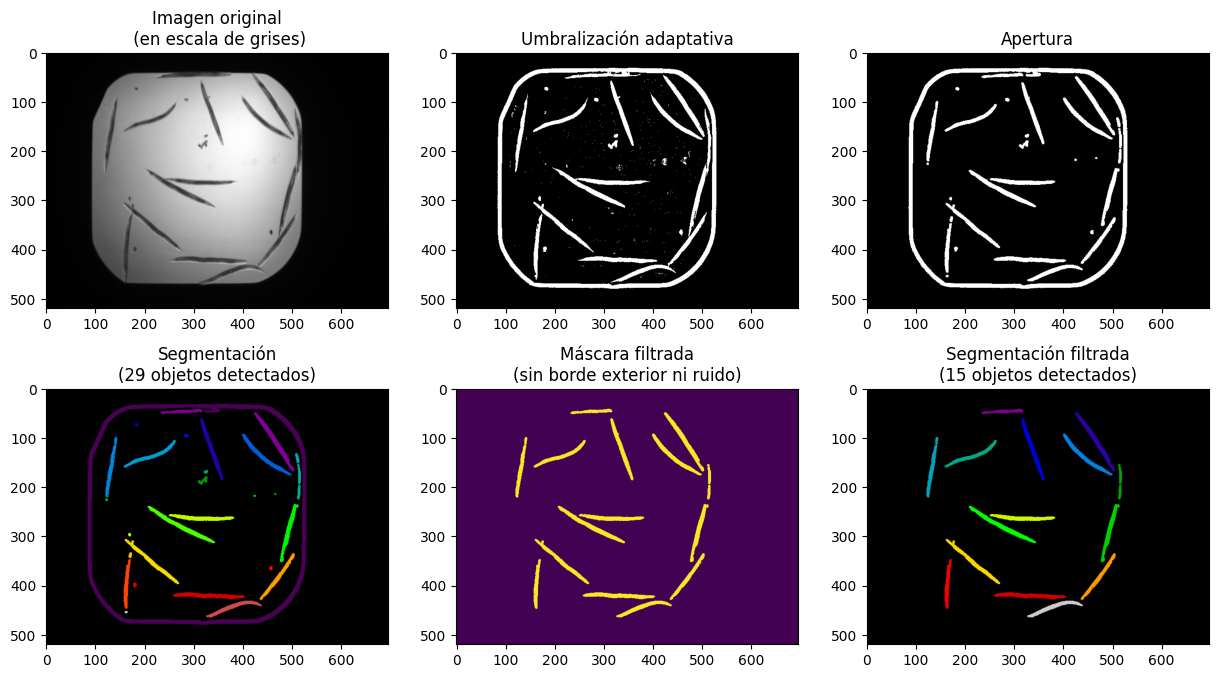

--------------------------------------------------------------------------------------------------------------------------------------------
                                                                 IMAGEN 2
--------------------------------------------------------------------------------------------------------------------------------------------


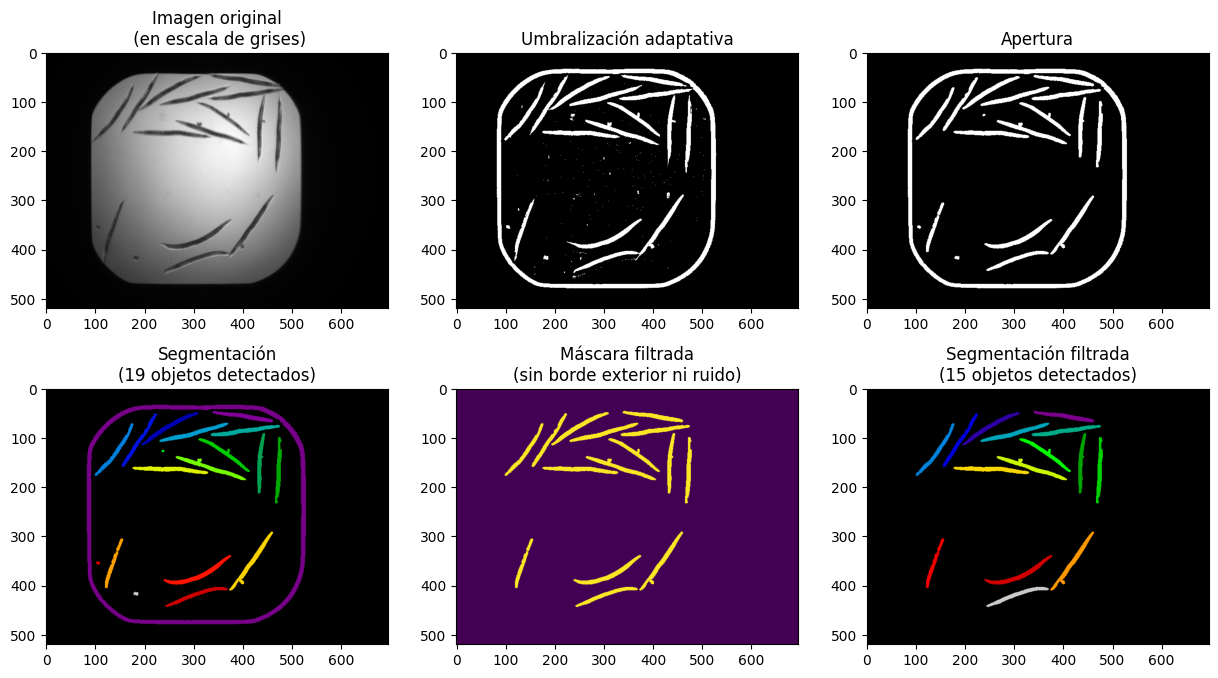

--------------------------------------------------------------------------------------------------------------------------------------------
                                                                 IMAGEN 3
--------------------------------------------------------------------------------------------------------------------------------------------


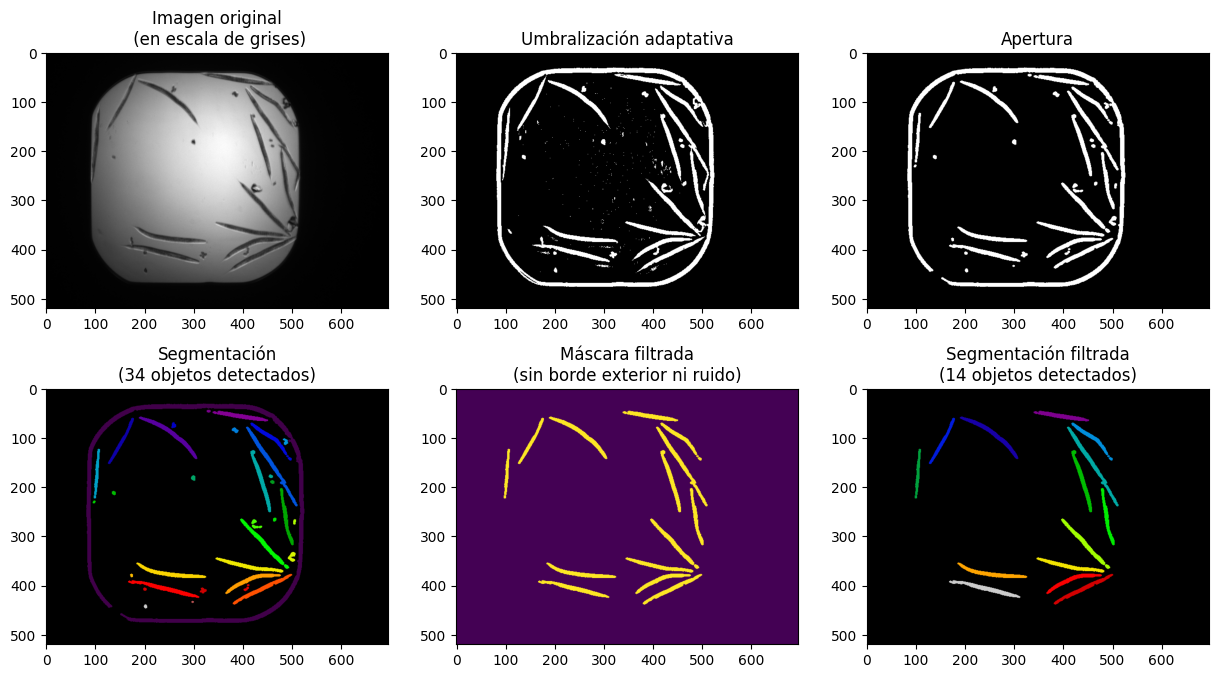

--------------------------------------------------------------------------------------------------------------------------------------------
                                                                 IMAGEN 4
--------------------------------------------------------------------------------------------------------------------------------------------


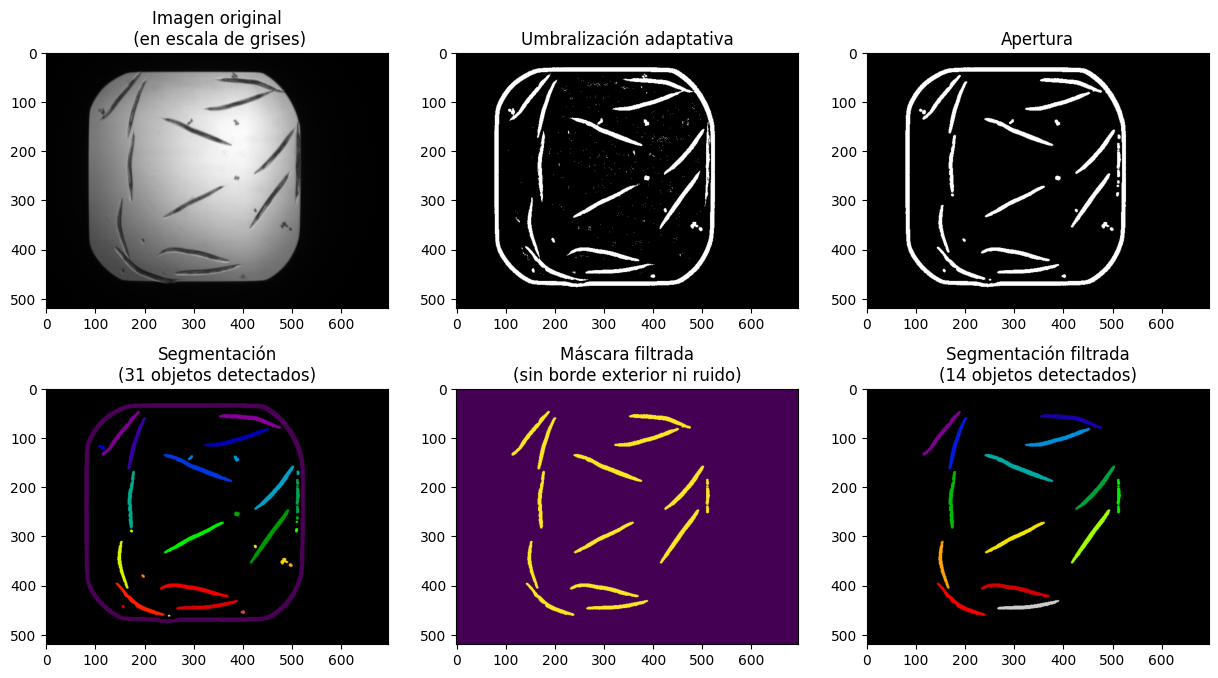

--------------------------------------------------------------------------------------------------------------------------------------------
                                                                 IMAGEN 5
--------------------------------------------------------------------------------------------------------------------------------------------


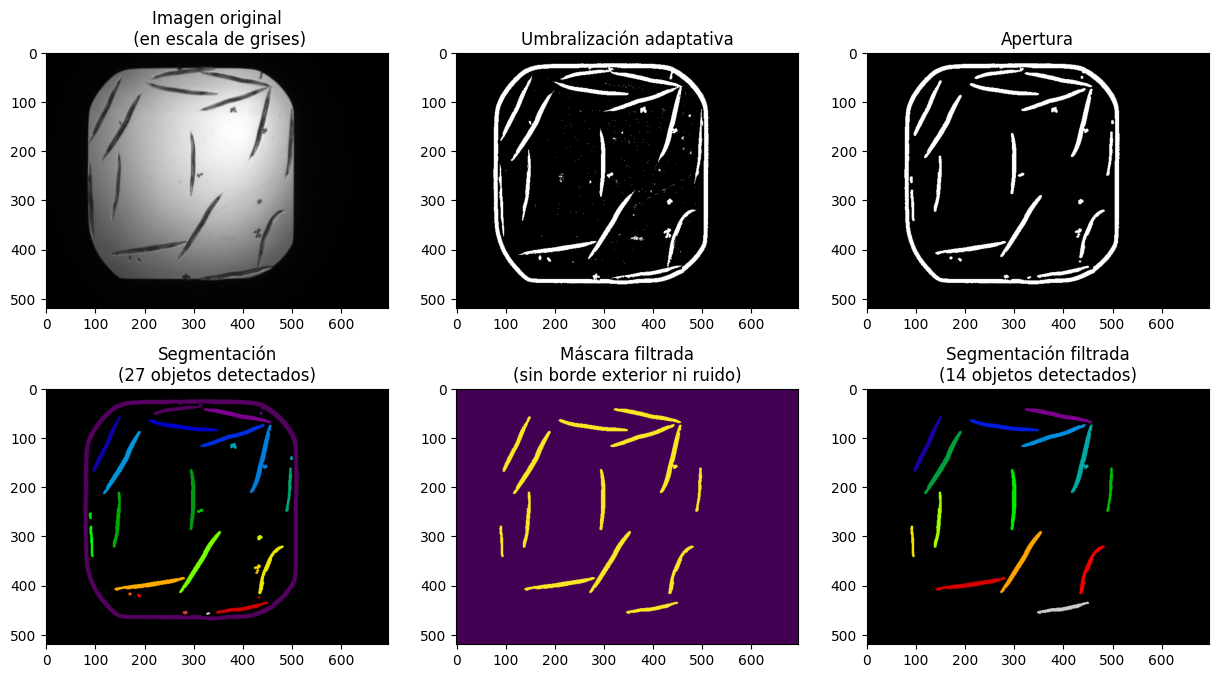

--------------------------------------------------------------------------------------------------------------------------------------------
                                                                 IMAGEN 6
--------------------------------------------------------------------------------------------------------------------------------------------


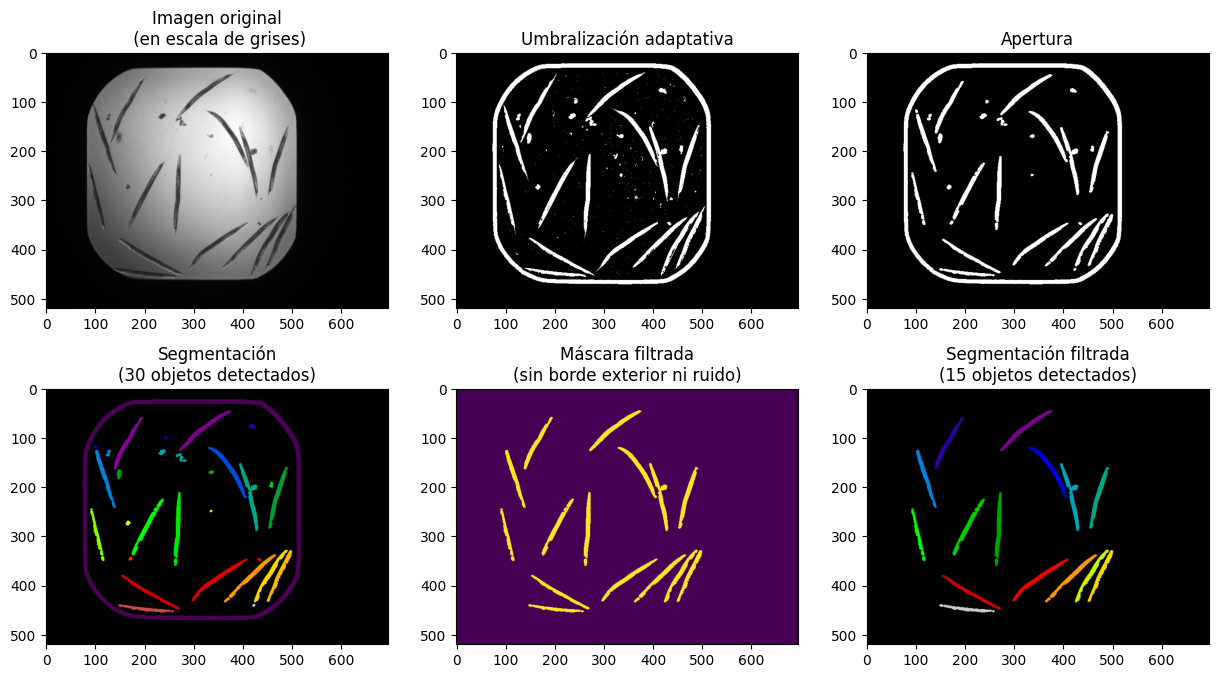

In [9]:
nematodos_por_imagen = {}

for i in range(len(images_rescaled)):
    print("-"*140)
    print(" "*65 + "IMAGEN {}".format(i+1))
    print("-"*140)

    num_labels, labels, centroids = segmentar_nematodos(images_rescaled[i][:,:,0], plot=True)

    # inicializamos diccionarios
    dicc_imagen = {}
    faringe = {}
    genes = {}

    # almacenamos también una entrada para cada nematodo (y el fondo)
    for nematodo_index in range(num_labels):
        # añadimos cada nematodo por su índice a los diccionarios de genes y faringe
        faringe.update({nematodo_index:[]})
        genes.update({nematodo_index:[]})
    
    # almacenamos en un diccionario por cada imagen su número de etiquetas, la matriz de etiquetas y otros dos diccionarios
    # para almacenar los centroides de genes y faringes, con una entrada para cada nematodo
    dicc_imagen.update({"num_labels":num_labels})
    dicc_imagen.update({"labels":labels}) 
    # dicc_imagen.update({"centroids":centroids})
    dicc_imagen.update({"faringe":faringe})
    dicc_imagen.update({"genes":genes})

    # actualizamos el diccionario principal
    nematodos_por_imagen.update({i+1:dicc_imagen})

    #print(nematodos_por_imagen[i+1])

#print(nematodos_por_imagen)

# Tarea 2: Identificación de la expresión de los genes

Ahora debemos detectar la expresión de los genes en el canal GFP. 

1. Después de realizar distintas configuraciones de parámetros de Umbralizacióna adaptativa + cierre y obtener problemas con la fusión de puntos próximos, acabé optando por utilizar la técnica **Floodfill** para umbralizar, la cual permite ir cubriendo el área de la imagen en busca de cambios de intensidad, comenzando desde un píxel (semilla) determinado (en este caso se eligió la esquina superior izqueirda).

2. Tras utilizar Floodfill decidí realizar una **segmentación** para obtener todos los puntos.

3. Luego **filtré por área**, excluyendo aquellos puntos de 1 solo píxel de superficie.

4. **Volví a segmentar** para identificar cada punto de los restantes.

5. Por último **dibujé sobre la imagen original los centroides** de los marcadores.

In [10]:
def segmentar_genes(imagen, fondo, plot=True):

    # realizamos una copia de las imágenes para no editarla
    imagen_copia = np.copy(imagen)
    fondo_copia = np.copy(fondo)

    # Floodfill
    imagen_uint8 = cv2.normalize(imagen_copia, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    mask = np.zeros((imagen_uint8.shape[0]+2, imagen_uint8.shape[1]+2), dtype=np.uint8)
    cv2.floodFill(imagen_uint8, mask, (0, 0), 12, 12, 8)
    mask = 1 - mask  # Invierte los valores

    # Segmentación
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask)
    
    # Crear una máscara para filtrar los objetos más pequeños (de 1 solo pixel)
    filtered_mask = np.zeros_like(labels, dtype=np.uint8)

    # Eliminar objetos de un solo pixel
    for i in range(1, num_labels):  # Evitamos el fondo (label 0)
        _, _, _, _, area = stats[i] # area: Cantidad de píxeles del objeto detectado
        if area > 1:
            filtered_mask[labels == i] = 255 

    # Nueva segmentación sobre la máscara
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(filtered_mask)

    # Ver marcadores sobre imagen original
    centroides = []
    for centroide in centroids[1:]:
        # convertimos a entero y ordenamos correctamente
        centroide_int_ordered = (int(centroide[0]), int(centroide[1]))
        # lo almacenamos en una lista
        centroides.append(centroide_int_ordered)
        # dibujar círculo blanco
        cv2.circle(fondo_copia, centroide_int_ordered, 6, (255,255,255), 2)

    # Gráficos (se pueden desactivar con el parámetro plot=False)
    if plot == True:
        fig, ax = plt.subplots(1,3, figsize=(15,8))

        # Imagen original
        ax[0].imshow(imagen_copia, cmap='gray')
        ax[0].set_title("Imagen original\n (en escala de grises)")

        # Floodfill + Segmentación + Filtrado
        ax[1].imshow(labels, cmap="nipy_spectral")
        ax[1].set_title("Floodfill + Segmentación + Filtrado\n({} objetos detectados)".format(num_labels-1))

        # Visualización de marcadores sobre imagen original
        ax[2].imshow(fondo_copia)
        ax[2].set_title("Imagen original + marcadores")

        plt.show()
    
    return centroides

Los centroides de los marcadores se guardan en un diccionario que contiene una entrada por imagen (**centroides_genes_por_imagen**). Con el índice de la imagen como clave (1-6) y como valor una lista con las coordenadas de cada centroide.

--------------------------------------------------------------------------------------------------------------------------------------------
                                                                 IMAGEN 1
--------------------------------------------------------------------------------------------------------------------------------------------


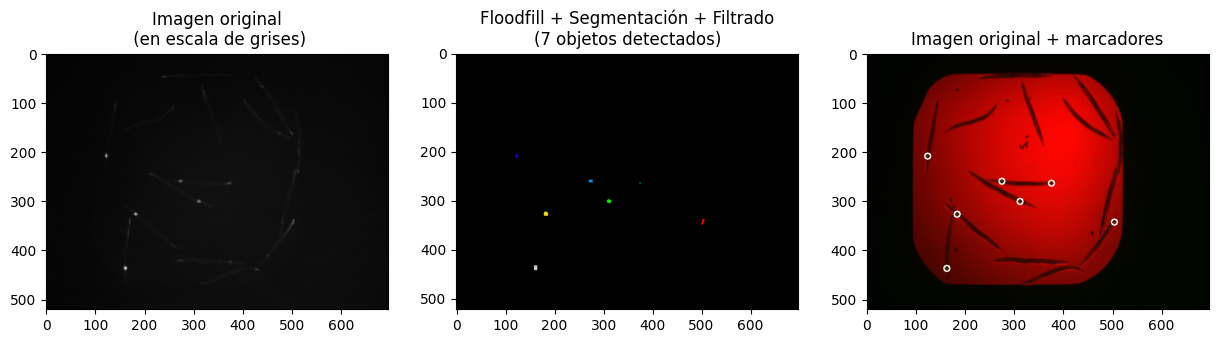

Centroides de marcadores:

[(123, 209), (274, 260), (375, 264), (311, 301), (183, 327), (503, 343), (162, 437)]
--------------------------------------------------------------------------------------------------------------------------------------------
                                                                 IMAGEN 2
--------------------------------------------------------------------------------------------------------------------------------------------


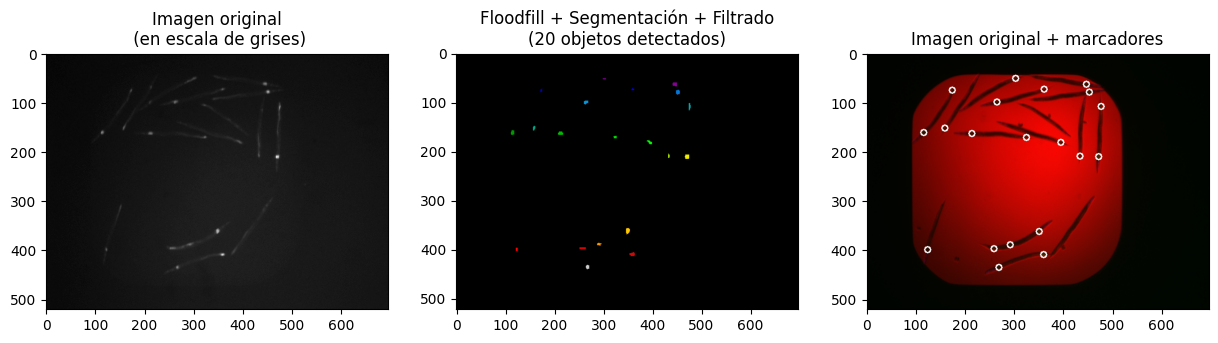

Centroides de marcadores:

[(302, 51), (446, 63), (173, 75), (360, 73), (452, 79), (264, 99), (476, 108), (158, 152), (115, 161), (213, 163), (324, 171), (394, 181), (433, 209), (471, 210), (350, 362), (291, 389), (123, 399), (258, 397), (359, 409), (268, 435)]
--------------------------------------------------------------------------------------------------------------------------------------------
                                                                 IMAGEN 3
--------------------------------------------------------------------------------------------------------------------------------------------


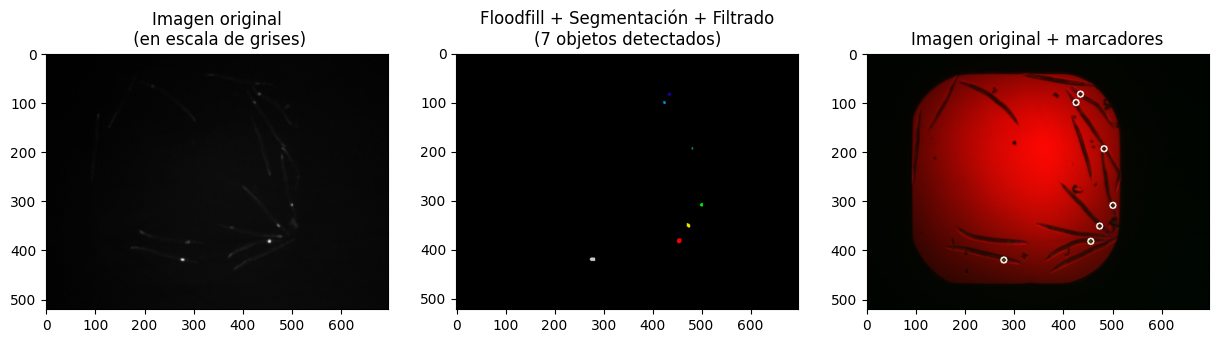

Centroides de marcadores:

[(434, 83), (425, 100), (482, 194), (500, 309), (473, 351), (455, 382), (278, 420)]
--------------------------------------------------------------------------------------------------------------------------------------------
                                                                 IMAGEN 4
--------------------------------------------------------------------------------------------------------------------------------------------


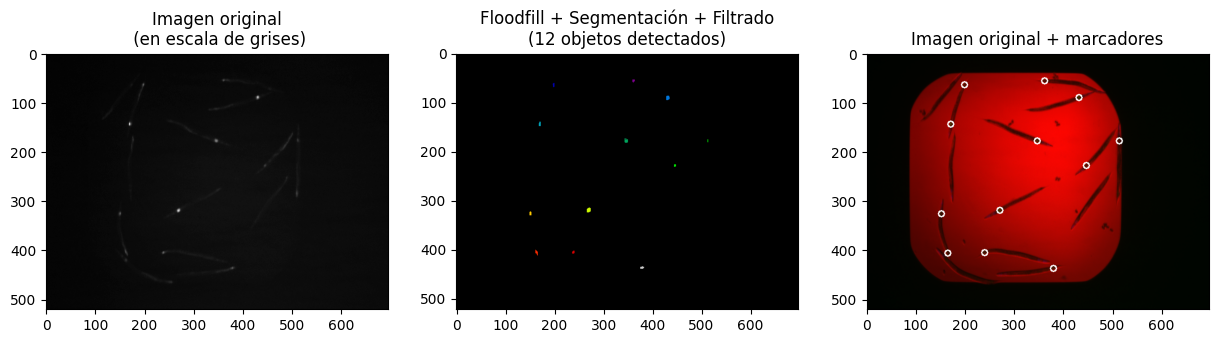

Centroides de marcadores:

[(361, 56), (198, 64), (431, 90), (170, 144), (346, 178), (513, 178), (446, 228), (270, 319), (151, 326), (164, 406), (239, 405), (379, 437)]
--------------------------------------------------------------------------------------------------------------------------------------------
                                                                 IMAGEN 5
--------------------------------------------------------------------------------------------------------------------------------------------


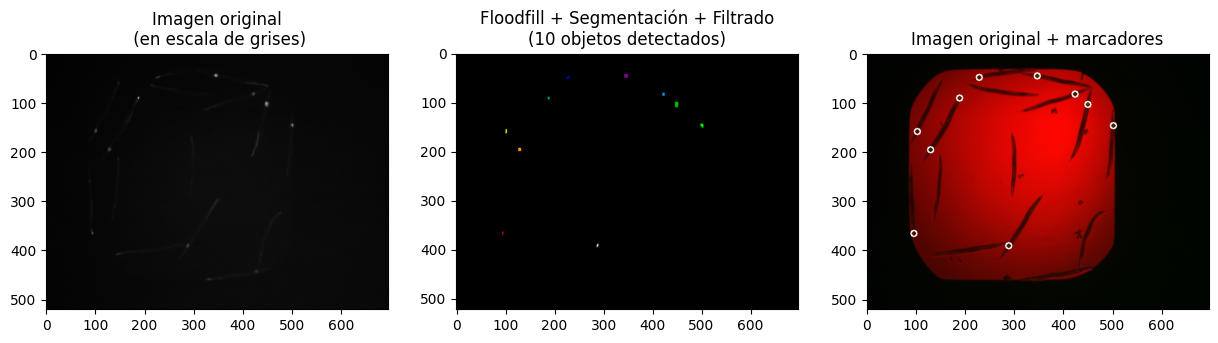

Centroides de marcadores:

[(346, 46), (228, 49), (423, 83), (188, 91), (449, 104), (501, 147), (102, 159), (129, 196), (95, 366), (288, 391)]
--------------------------------------------------------------------------------------------------------------------------------------------
                                                                 IMAGEN 6
--------------------------------------------------------------------------------------------------------------------------------------------


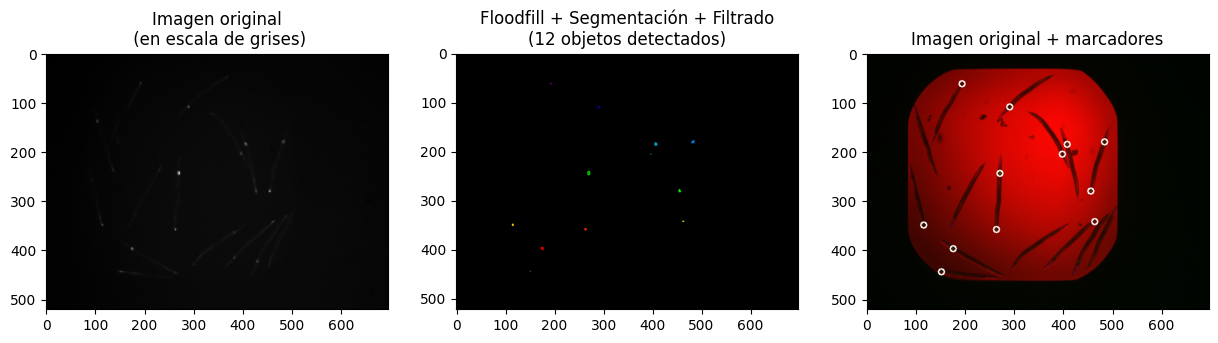

Centroides de marcadores:

[(193, 62), (290, 109), (483, 180), (407, 185), (397, 205), (270, 244), (455, 280), (463, 342), (115, 349), (263, 358), (175, 397), (151, 444)]


In [11]:
centroides_genes_por_imagen = {}

for i in range(len(images_rescaled)):
    print("-"*140)
    print(" "*65 + "IMAGEN {}".format(i+1))
    print("-"*140)

    centroides_genes = segmentar_genes(images_rescaled[i][:,:,1], images_rescaled[i], plot=True)
    print("Centroides de marcadores:\n\n" + str(centroides_genes))

    centroides_genes_por_imagen.update({i+1:centroides_genes})

# Tarea 3: Extracción de la faringe

Ahora debemos detectar la faringe a partir del canal mCheery.

La misma combinación de técnicas funciona muy bien para segmentar las faringes. El único problema es que se detectan dos puntos por cada faringe. Intenté cerrar los istmos entre ambos puntos pero lo que acaba ocurriendo es que también se cierran los istmos entre puntos de faringes distintas que están próximos. Teniendo esto en cuenta he decidido detectar dos puntos por faringe y en la fase siguiente, asignar únicamente uno por cada nematodo segmentado.

In [12]:
def segmentar_faringe(imagen, fondo, plot=True):
    
    fig, ax = plt.subplots(1,3, figsize=(15,8))

    # realizamos una copia de las imágenes para no editarla
    imagen_copia = np.copy(imagen)
    fondo_copia = np.copy(fondo)

    # Floodfill
    imagen_uint8 = cv2.normalize(imagen_copia, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    mask = np.zeros((imagen_uint8.shape[0]+2, imagen_uint8.shape[1]+2), dtype=np.uint8)
    cv2.floodFill(imagen_uint8, mask, (0, 0), 12, 12, 8)
    mask = 1 - mask  # Invierte los valores

    # Segmentación
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask)
    
    # Crear una máscara para filtrar los objetos más pequeños (de 1 solo pixel)
    filtered_mask = np.zeros_like(labels, dtype=np.uint8)

    # Eliminar objetos de un solo pixel
    for i in range(1, num_labels):  # Evitamos el fondo (label 0)
        _, _, _, _, area = stats[i] # area: Cantidad de píxeles del objeto detectado
        if area > 1:
            filtered_mask[labels == i] = 255 

    # Nueva segmentación sobre la máscara
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(filtered_mask)

    ax[1].imshow(labels, cmap="nipy_spectral")
    ax[1].set_title("Floodfill + Segmentación + Filtrado\n({} objetos detectados)".format(num_labels-1))

    # Ver marcadores sobre imagen original
    centroides = []
    for centroide in centroids[1:]:
        # convertimos a entero y ordenamos correctamente
        centroide_int_ordered = (int(centroide[0]), int(centroide[1]))
        # lo almacenamos en una lista
        centroides.append(centroide_int_ordered)
        # dibujar círculo blanco
        cv2.circle(fondo_copia, centroide_int_ordered, 6, (255,255,255), 2)

    if plot==True:
        
        # Imagen original
        ax[0].imshow(imagen_copia, cmap='gray')
        ax[0].set_title("Imagen original\n (en escala de grises)")

        # Nueva segmentación
        ax[1].imshow(labels, cmap="nipy_spectral")
        ax[1].set_title("Floodfill + Segmentación + Filtrado\n({} objetos detectados)".format(num_labels-1))
        
        # Marcadores sobre imagen original
        ax[2].imshow(fondo_copia)
        ax[2].set_title("Imagen original + marcadores")

        plt.show()
    
    return centroides

Los centroides de las faringes se guardan en un diccionario que contiene una entrada por imagen (**centroides_faringes_por_imagen**). Con el índice de la imagen como clave (1-6) y como valor una lista con las coordenadas de cada centroide.

--------------------------------------------------------------------------------------------------------------------------------------------
                                                                 IMAGEN 1
--------------------------------------------------------------------------------------------------------------------------------------------


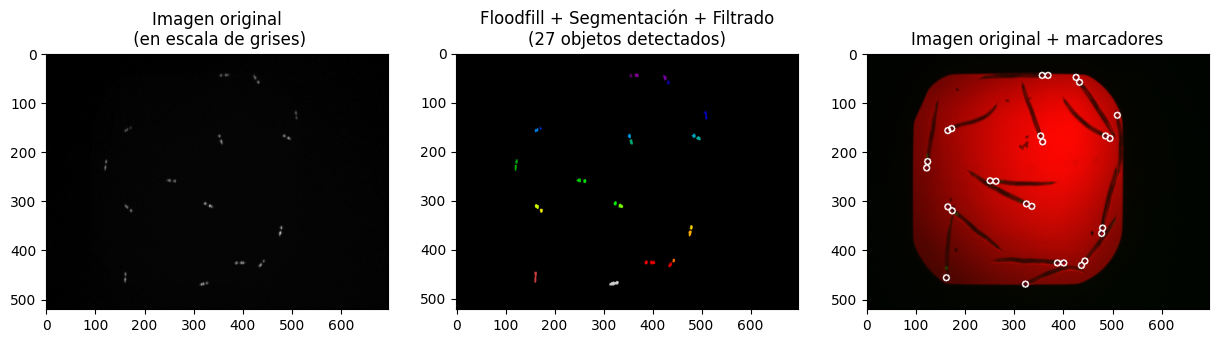

Centroides de faringes:

[(356, 45), (368, 45), (425, 49), (432, 59), (509, 126), (172, 153), (164, 157), (353, 168), (485, 168), (494, 173), (357, 180), (123, 220), (121, 233), (250, 259), (262, 260), (324, 306), (335, 311), (164, 312), (173, 320), (479, 355), (477, 366), (443, 422), (387, 426), (400, 426), (436, 431), (161, 456), (322, 469)]
--------------------------------------------------------------------------------------------------------------------------------------------
                                                                 IMAGEN 2
--------------------------------------------------------------------------------------------------------------------------------------------


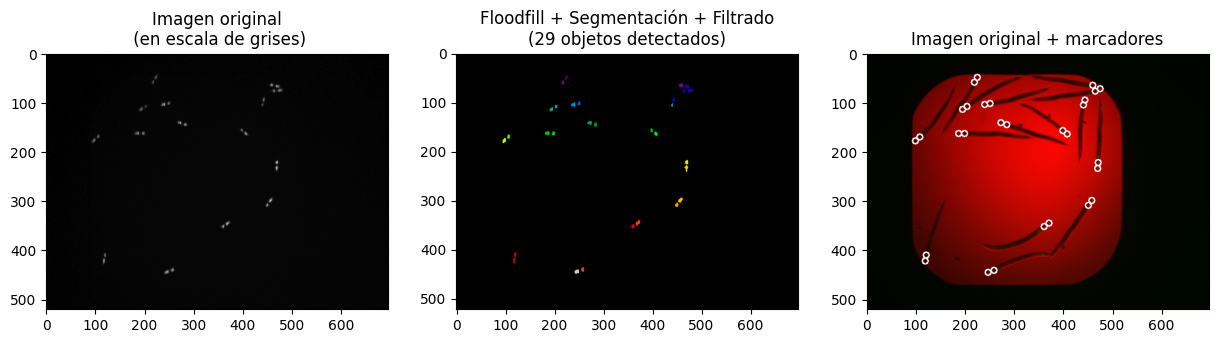

Centroides de faringes:

[(224, 49), (218, 59), (459, 65), (474, 72), (464, 77), (443, 95), (250, 102), (239, 104), (440, 105), (203, 108), (194, 114), (272, 141), (284, 145), (398, 157), (186, 163), (198, 163), (407, 164), (107, 170), (98, 178), (470, 222), (469, 234), (457, 299), (450, 309), (370, 345), (360, 352), (120, 410), (118, 422), (258, 441), (246, 445)]
--------------------------------------------------------------------------------------------------------------------------------------------
                                                                 IMAGEN 3
--------------------------------------------------------------------------------------------------------------------------------------------


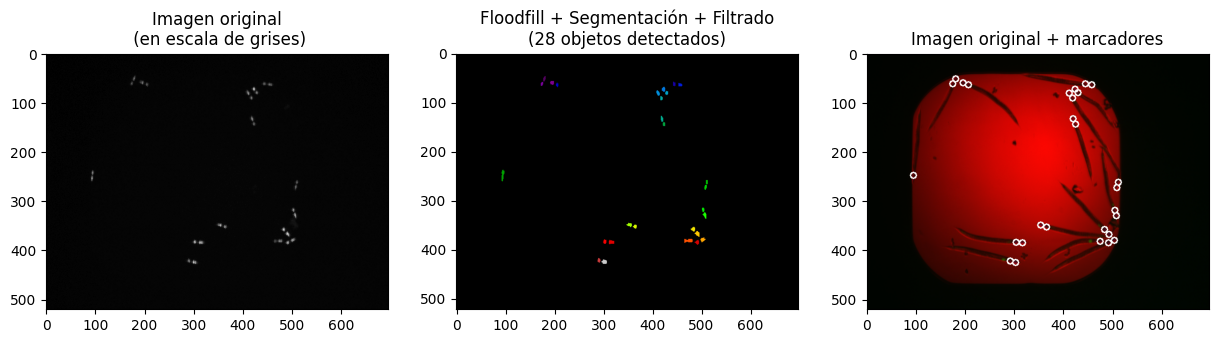

Centroides de faringes:

[(180, 52), (195, 60), (174, 62), (444, 62), (206, 64), (457, 64), (423, 73), (411, 81), (429, 80), (418, 91), (419, 133), (424, 144), (94, 248), (511, 262), (508, 273), (504, 319), (507, 330), (353, 349), (365, 353), (483, 358), (492, 368), (503, 380), (474, 382), (303, 384), (316, 385), (491, 385), (291, 422), (302, 425)]
--------------------------------------------------------------------------------------------------------------------------------------------
                                                                 IMAGEN 4
--------------------------------------------------------------------------------------------------------------------------------------------


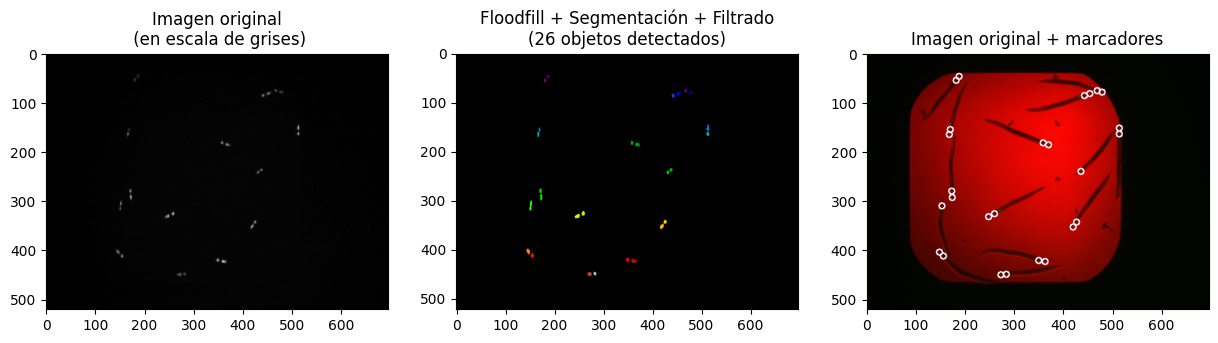

Centroides de faringes:

[(187, 47), (181, 55), (468, 76), (478, 79), (453, 82), (442, 86), (513, 152), (169, 155), (167, 165), (513, 164), (358, 182), (369, 186), (435, 240), (172, 280), (173, 293), (152, 310), (259, 326), (247, 332), (426, 343), (419, 353), (147, 404), (155, 412), (349, 421), (362, 423), (272, 450), (283, 449)]
--------------------------------------------------------------------------------------------------------------------------------------------
                                                                 IMAGEN 5
--------------------------------------------------------------------------------------------------------------------------------------------


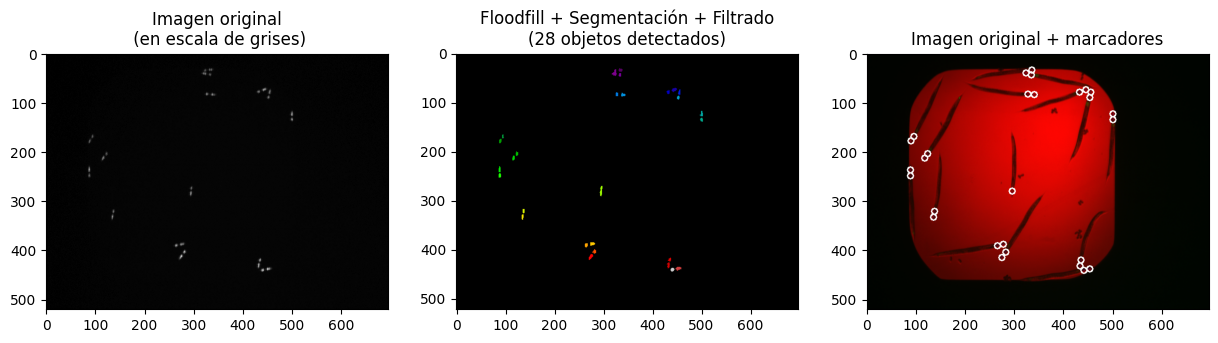

Centroides de faringes:

[(335, 34), (323, 40), (334, 44), (445, 74), (432, 79), (455, 79), (327, 83), (340, 84), (453, 90), (500, 123), (500, 135), (95, 169), (89, 178), (123, 204), (117, 213), (88, 237), (88, 249), (295, 280), (137, 321), (135, 333), (277, 388), (265, 391), (282, 404), (274, 415), (435, 420), (433, 432), (453, 438), (441, 441)]
--------------------------------------------------------------------------------------------------------------------------------------------
                                                                 IMAGEN 6
--------------------------------------------------------------------------------------------------------------------------------------------


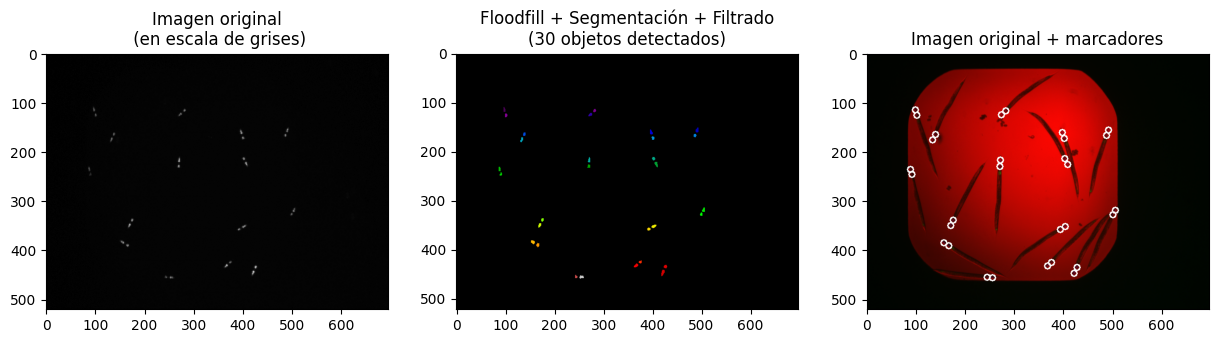

Centroides de faringes:

[(98, 115), (282, 117), (101, 126), (273, 125), (491, 156), (397, 161), (139, 165), (487, 167), (401, 173), (133, 176), (271, 217), (402, 214), (408, 226), (270, 230), (88, 236), (91, 246), (505, 319), (500, 328), (175, 339), (170, 350), (403, 352), (393, 358), (156, 385), (166, 391), (375, 425), (367, 432), (427, 435), (421, 447), (244, 455), (255, 456)]
{1: [(356, 45), (368, 45), (425, 49), (432, 59), (509, 126), (172, 153), (164, 157), (353, 168), (485, 168), (494, 173), (357, 180), (123, 220), (121, 233), (250, 259), (262, 260), (324, 306), (335, 311), (164, 312), (173, 320), (479, 355), (477, 366), (443, 422), (387, 426), (400, 426), (436, 431), (161, 456), (322, 469)], 2: [(224, 49), (218, 59), (459, 65), (474, 72), (464, 77), (443, 95), (250, 102), (239, 104), (440, 105), (203, 108), (194, 114), (272, 141), (284, 145), (398, 157), (186, 163), (198, 163), (407, 164), (107, 170), (98, 178), (470, 222), (469, 234), (457, 299), (450, 309), (370, 345), (360, 

In [13]:
centroides_faringes_por_imagen = {}

for i in range(len(images_rescaled)):
    print("-"*140)
    print(" "*65 + "IMAGEN {}".format(i+1))
    print("-"*140)

    centroides_faringes = segmentar_faringe(images_rescaled[i][:,:,2], images_rescaled[i], plot=True)
    print("Centroides de faringes:\n\n" + str(centroides_faringes))

    centroides_faringes_por_imagen.update({i+1:centroides_faringes})

print(centroides_faringes_por_imagen)

# Tarea 4: Localización de las estructuras

Una vez identificadas las expresiones de los genes y las faringes, el siguiente paso será relacionar de forma automática estas estructuras con respecto a los individuos.

Para el caso de las faringes, como ya sabemos del anterior paso, hay más de un centroide para cada nematodo. Por lo que debemos de almacenar solamente uno de ellos por nematodo. 

Además tenemos otro problema: la mayor parte de los centroides no caen en el área de ningún nematodo, por lo que debemos de calcular cual es el nematodo más próximo al centroide de cada faringe.

In [14]:
for image in range(1, n_images):
    
    # Calculamos la transformada de distancia de la matriz de labels
    dist_transform, indices = distance_transform_edt(nematodos_por_imagen[image]['labels'] == 0, return_indices=True)

    for centroide in centroides_faringes_por_imagen[image]:
        # Coordenadas del píxel más cercano con valor distinto de cero
        y_c, x_c = centroide
        y_nearest, x_nearest = indices[:, x_c, y_c]  # Obtiene el píxel más cercano

        # Obtenemos la etiqueta del nematodo al que pertenece el píxel más cercano
        label = nematodos_por_imagen[image]['labels'][y_nearest, x_nearest]

        # Si el píxel pertenece a un nematodo válido (distinto de 0)
        if label != 0:
            # Evitamos duplicados en la lista
            if len(nematodos_por_imagen[image]['faringe'][label]) == 0:
                nematodos_por_imagen[image]['faringe'][label] = centroide  # Guarda la primera faringe encontrada

    # Imprimir la estructura final con las faringes asignadas
    print("-"*230)
    print(" "*110 + "IMAGEN {}".format(image))
    print("-"*230)
    print(nematodos_por_imagen[image]['faringe'])
print("-"*230)

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                              IMAGEN 1
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
{0: [], 1: (356, 45), 2: (425, 49), 3: (353, 168), 4: (485, 168), 5: (123, 220), 6: (172, 153), 7: [], 8: (479, 355), 9: (324, 306), 10: (250, 259), 11: (164, 312), 12: (477, 366), 13: (161, 456), 14: (387, 426), 15: (322, 469)}
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Ahora asignamos los centroides de los genes. Esta vez, cada nematodo sí puede tener más de un centroide asignado.

In [15]:
for image in range(1, n_images):
    
    # Calculamos la transformada de distancia de la máscara binaria de nematodos
    dist_transform, indices = distance_transform_edt(nematodos_por_imagen[image]['labels'] == 0, return_indices=True)

    for centroide in centroides_genes_por_imagen[image]:
        # Coordenadas del píxel más cercano con valor distinto de cero
        y_c, x_c = centroide
        y_nearest, x_nearest = indices[:, x_c, y_c]  # Obtiene el píxel más cercano en la segmentación

        # Obtenemos la etiqueta del nematodo al que pertenece el píxel más cercano
        label = nematodos_por_imagen[image]['labels'][y_nearest, x_nearest]

        # Si el píxel pertenece a un nematodo válido (distinto de 0)
        if label != 0:
            # Evitamos duplicados en la lista
            if centroide not in nematodos_por_imagen[image]['genes'][label]:
                nematodos_por_imagen[image]['genes'][label].append(centroide)
    # Imprimir la estructura final con las genes asignadas
    print("-"*230)
    print(" "*110 + "IMAGEN {}".format(image))
    print("-"*230)
    print(nematodos_por_imagen[image]['genes'])
print("-"*230)

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                              IMAGEN 1
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
{0: [], 1: [], 2: [], 3: [], 4: [], 5: [(123, 209)], 6: [], 7: [], 8: [], 9: [(311, 301)], 10: [(274, 260), (375, 264)], 11: [(183, 327)], 12: [(503, 343)], 13: [(162, 437)], 14: [], 15: []}
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Ahora mostramos la máscara de etiquetas de cada imagen y sus respectivos marcadores.

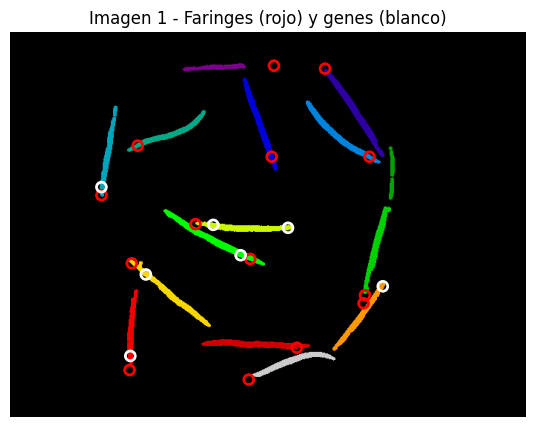

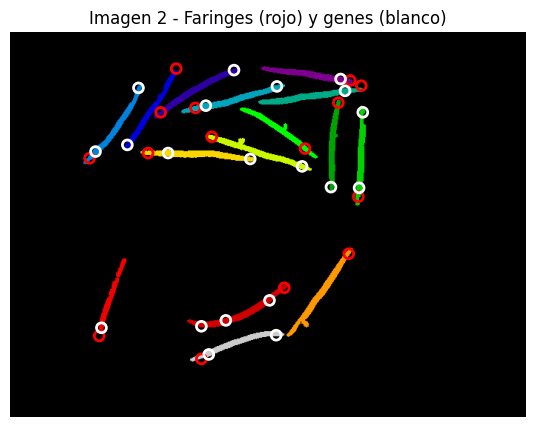

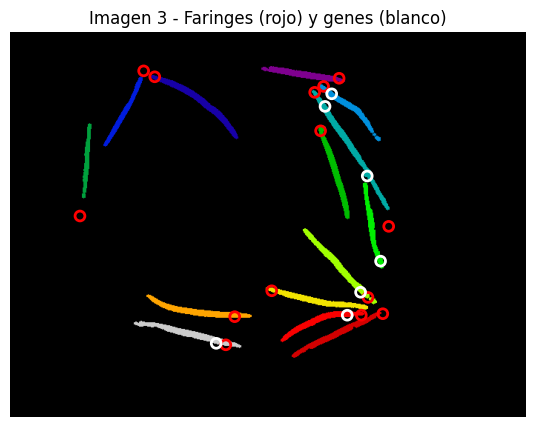

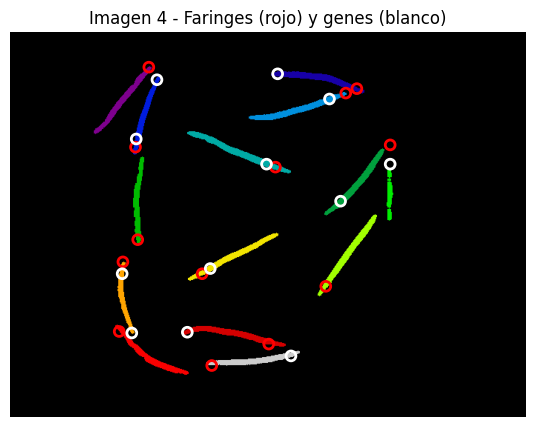

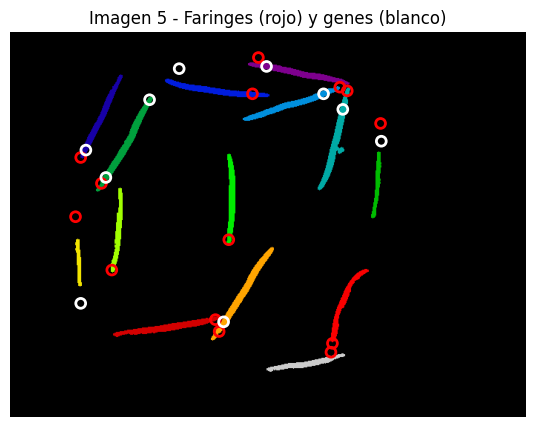

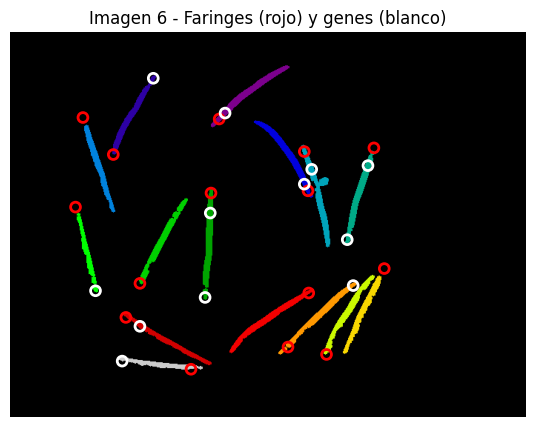

In [16]:
for image in range(1, n_images):
    
    # Cargamos la máscara de etiquetas (labels)
    label_mask = nematodos_por_imagen[image]['labels'].copy()

    plt.figure(figsize=(10, 5))
    plt.imshow(label_mask, cmap="nipy_spectral")

    # Dibujamos las faringes en rojo
    for label, faringe in nematodos_por_imagen[image]['faringe'].items():
        if faringe:
            plt.scatter(faringe[0], faringe[1], facecolors='none', edgecolors='red', s=50, linewidths=2, label='Faringe')

    # Dibujamos los genes en blanco
    for label, genes in nematodos_por_imagen[image]['genes'].items():
        for gene in genes:
            plt.scatter(gene[0], gene[1], facecolors='none', edgecolors='white', s=50, linewidths=2, label='Gen')

    plt.title(f'Imagen {image} - Faringes (rojo) y genes (blanco)')
    plt.axis("off")
    plt.show()


Ahora configuramos una manera de mostrar únicamente un nematodo de una imagen con sus respectivos marcadores.

In [17]:
def mostrar_nematodo(image, nematodo_id):

    # Cargamos la máscara de etiquetas (labels)
    label_mask = nematodos_por_imagen[image]['labels'].copy()

    # Creamos una máscara para mostrar solo el nematodo seleccionado
    nematodo_mask = np.where(label_mask == nematodo_id, label_mask, 0)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(nematodo_mask, cmap="nipy_spectral")

    # Dibujamos la faringe si existe
    if nematodo_id in nematodos_por_imagen[image]['faringe']:
        faringe = nematodos_por_imagen[image]['faringe'][nematodo_id]
        if faringe:
            plt.scatter(faringe[0], faringe[1], facecolors='none', edgecolors='red', s=50, linewidths=2, label='Faringe')

    # Dibujamos los genes si existen
    if nematodo_id in nematodos_por_imagen[image]['genes']:
        genes = nematodos_por_imagen[image]['genes'][nematodo_id]
        for gene in genes:
            plt.scatter(gene[0], gene[1], facecolors='none', edgecolors='white', s=50, linewidths=2, label='Gen')

    plt.title(f'Imagen {image} - Nematodo {nematodo_id}')
    plt.axis("off")
    plt.show()

Por ejemplo, probamos a usarlo con el nematodo 7 de la imagen 6.

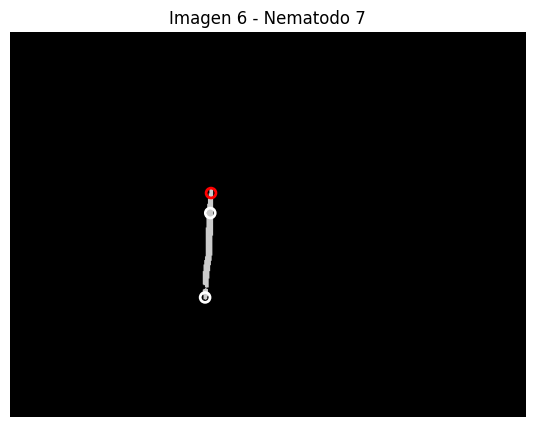

In [18]:
mostrar_nematodo(image=6, nematodo_id=7)